Initially connects to the azure server. Needs to be filled by specific user's azure information. 

In [ ]:
import qsharp.azure
targets = qsharp.azure.connect(
    resourceId="...",
    location="westus")
SimpleHashCollisions: any = None

Main Q# code. Implementation of Grover's search algorithm mainly sourced from [here.](https://learn.microsoft.com/en-us/azure/quantum/tutorial-qdk-grovers-search?tabs=tabid-visualstudio)

In [ ]:
%%qsharp
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Arithmetic;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Preparation;

@EntryPoint()
operation SimpleHashCollisions(hash : Int) : Result[] {
    mutable permutationArray = new Int[128];
    for (i in 0 .. 127) {
        set permutationArray w/= i <- (3123 * 458 + (i * i)) % 128; 
    }
    let inputBitSize = 5;
    let markingOracle = MarkHasher(hash, _, _, permutationArray);
    let phaseOracle = ApplyMarkingOracleAsPhaseOracle(markingOracle, _);
    let totalHashes = 32; // 2 ** inputBitSize
    let nSolutions = 8; // 8 - 5 = 3, 2 ** 3
    let nIterations = Round(PI() / 4.0 * Sqrt(IntAsDouble(totalHashes) / IntAsDouble(nSolutions)));
    use register = Qubit[8];
    RunGroversSearch(register, phaseOracle, nIterations);
    let res = MultiM(register);
    return res;
}

operation MarkHasher (
hashToCheck : Int,
inputQubits : Qubit[],
target : Qubit,
permutationArray : Int[]
) : Unit is Adj + Ctl {
use checkQubits = Qubit[5];
use hashedQubits = Qubit[5];
    
let inp = LittleEndian(inputQubits);
let check = LittleEndian(checkQubits);
let hashed = LittleEndian(hashedQubits);
within {
    ApplyXorInPlace(hashToCheck, check);
    for (i in 217 .. 221) {
        ApplyXorInPlace(permutationArray[(i * i)%128], inp);
    }
    for (i in 0 .. Length(hashedQubits) - 1) {
        CNOT(inputQubits[i],hashedQubits[i]);
    }
    for (i in 0 .. Length(checkQubits) - 1) {
        CNOT(hashedQubits[i],checkQubits[i]);
    }
    ApplyToEachA(X, checkQubits);
} apply {
    Controlled X(checkQubits, target);
    }
}

operation PrepareUniformSuperpositionOverDigits(digitReg : Qubit[]) : Unit is Adj + Ctl {
    PrepareArbitraryStateCP(ConstantArray(10, ComplexPolar(1.0, 0.0)), LittleEndian(digitReg));
}

operation ApplyMarkingOracleAsPhaseOracle(
    markingOracle : (Qubit[], Qubit) => Unit is Adj,
    register : Qubit[]
) : Unit is Adj {
    use target = Qubit();
    within {
        X(target);
        H(target);
    } apply {
        markingOracle(register, target);
    }
}

operation RunGroversSearch(register : Qubit[], phaseOracle : ((Qubit[]) => Unit is Adj), iterations : Int) : Unit {
    ApplyToEach(H, register);
    for _ in 1 .. iterations {
        phaseOracle(register);
        ReflectAboutUniform(register);
    }
}

operation ReflectAboutUniform(inputQubits : Qubit[]) : Unit {
    within {
        ApplyToEachA(H, inputQubits);
        ApplyToEachA(X, inputQubits);
    } apply {
            Controlled Z(Most(inputQubits), Tail(inputQubits));
    }
}


This connects python to the remote server instance and runs the code 100 times with a hash value of 7 (or 0b00111)

In [ ]:
qsharp.azure.target("ionq.qpu.aria-1")

result = qsharp.azure.execute(SimpleHashCollisions,hash=7, shots=100, jobName="Calculate collisions")

After the job is completed, displays data visually. 

In [ ]:
from matplotlib import pyplot
pyplot.bar(result.keys(), result.values())
pyplot.title("Hash collisions on n = 8 input size and m = 5 hash size")
pyplot.xlabel("Input  (converted from binary)")
pyplot.xscale("linear")
pyplot.ylabel("Probability")
for i, j in zip(result.keys(), result.values()):
    if (j > 0.07):
        print(i.replace(',',""))
pyplot.show()

Output on the cloud simulator will look like:
[00010000]
[00010100]
[00010010]
[00010110]
[00010001]
[00010101]
[00010011]
[00010111]

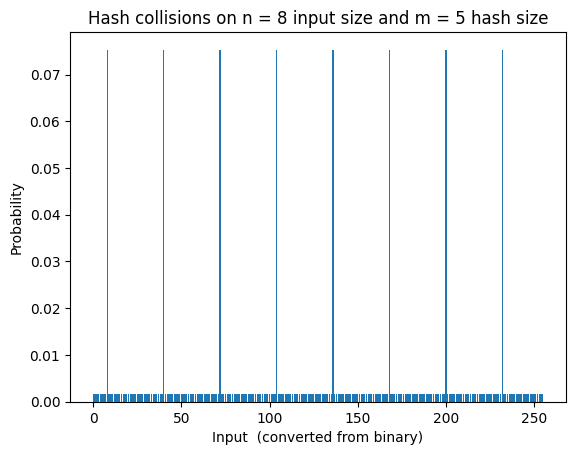
